In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations
from collections import defaultdict
import time
from collections import defaultdict
import matplotlib.pyplot as plt

# Load dataset

In [ ]:
dataset_path = '/content/drive/MyDrive/MMDS/baskets.csv'
df = pd.read_csv(dataset_path)

In [ ]:
df.head(5)

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1249,01/01/2014,citrus fruit,2014,1,1,2
1,1249,01/01/2014,coffee,2014,1,1,2
2,1381,01/01/2014,curd,2014,1,1,2
3,1381,01/01/2014,soda,2014,1,1,2
4,1440,01/01/2014,other vegetables,2014,1,1,2


# Preprocessing dataset

View dataset's information

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
 3   year             38765 non-null  int64 
 4   month            38765 non-null  int64 
 5   day              38765 non-null  int64 
 6   day_of_week      38765 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 2.1+ MB


Check if any column contains null values.

In [ ]:
print(df[df.isnull().any(axis=1)])

Empty DataFrame
Columns: [Member_number, Date, itemDescription, year, month, day, day_of_week]
Index: []


Check if any column contains missing values.

In [ ]:
print(df[df.isna().any(axis=1)])

Empty DataFrame
Columns: [Member_number, Date, itemDescription, year, month, day, day_of_week]
Index: []


Drop row duplicates

In [ ]:
df = df.drop_duplicates()

# Filter to find Baskets Dataset

We only consider the first 3 columns.

In [ ]:
df.iloc[:, :3].head(5)

,Member_number,Date,itemDescription
0,1249,01/01/2014,citrus fruit
1,1249,01/01/2014,coffee
2,1381,01/01/2014,curd
3,1381,01/01/2014,soda
4,1440,01/01/2014,other vegetables


Each basket is a set of items that a customer bought on 1 date.

In [ ]:
basket_tmp = (df.iloc[:, :3]
            .groupby(["Member_number", "Date"])
            .agg(list).reset_index())

In [ ]:
basket_tmp.head(5)

,Member_number,Date,itemDescription
0,1000,15/03/2015,"[sausage, whole milk, semi-finished bread, yog..."
1,1000,24/06/2014,"[whole milk, pastry, salty snack]"
2,1000,24/07/2015,"[canned beer, misc. beverages]"
3,1000,25/11/2015,"[sausage, hygiene articles]"
4,1000,27/05/2015,"[soda, pickled vegetables]"


Now, we only consider the last column

In [ ]:
basket = basket_tmp.iloc[:, -1]

In [ ]:
basket.head(5)

,itemDescription
0,"[sausage, whole milk, semi-finished bread, yog..."
1,"[whole milk, pastry, salty snack]"
2,"[canned beer, misc. beverages]"
3,"[sausage, hygiene articles]"
4,"[soda, pickled vegetables]"


Convert Pandas DataFrame to list of list (list of basket).

In [ ]:
data = basket.to_list()

In [ ]:
data[:5]

[['sausage', 'whole milk', 'semi-finished bread', 'yogurt'],
 ['whole milk', 'pastry', 'salty snack'],
 ['canned beer', 'misc. beverages'],
 ['sausage', 'hygiene articles'],
 ['soda', 'pickled vegetables']]

# Apriori Class

In [ ]:
class Apriori:
    def __init__(self, min_support=0.005):
        """
        Params and Attributes:
            min_support: minimum support, float type, default value is 0.005
            min_count: minimum count, int type, default value is 0
            fq_item_count_dict: dict type, key=item, value=count
            fq_pair_count_dict: dict type, key=pair, value=count
            baskets: list type, each element is a basket (list)
        """
        self.min_support = min_support
        self.min_count = 0
        self.fq_item_count_dict = defaultdict(int)
        self.fq_pair_count_dict = defaultdict(int)
        self.baskets = None

    def fit(self, baskets):
        """
        Fit the model with baskets. Finding frequent items and pairs.

        Params:
            baskets: list type, each element is a basket (list)
        """


        """Just ensure again that we avoid duplicate items in each basket"""
        self.baskets = [set(basket) for basket in baskets]

        """Calculate min_count"""
        self.min_count = self.min_support * len(self.baskets)

        self.pass1()
        self.pass2()

    def pass1(self):
        """
        Find frequent items.
        """

        """Count each item"""
        for basket in self.baskets:
            for item in basket:
                    self.fq_item_count_dict[item] += 1

        """Filter frequent items"""
        self.fq_item_count_dict = ({item: count
                    for item, count in self.fq_item_count_dict.items()
                        if count >= self.min_count})

    def pass2(self):
        """
        Find frequent pairs.
        """
        fq_items = self.fq_item_count_dict.keys()

        for basket in self.baskets:
            """Only consider frquent items in a basket, we do intersection"""
            intersect = list(set(basket).intersection(fq_items))
            pairs = list(combinations(intersect, 2))

            """Count each candidate pair"""
            for pair in pairs:
                self.fq_pair_count_dict[tuple(sorted(pair))] += 1

        """Filter frequent pairs"""
        self.fq_pair_count_dict = ({pair: count
                    for pair, count in self.fq_pair_count_dict.items()
                        if count >= self.min_count})

# Testing Apriori

In [ ]:
apriori = Apriori()
apriori.fit(data)

In [ ]:
apriori.fq_pair_count_dict

{('sausage', 'whole milk'): 134,
 ('whole milk', 'yogurt'): 167,
 ('sausage', 'yogurt'): 86,
 ('pastry', 'whole milk'): 97,
 ('rolls/buns', 'whole milk'): 209,
 ('rolls/buns', 'sausage'): 80,
 ('soda', 'whole milk'): 174,
 ('pip fruit', 'whole milk'): 99,
 ('tropical fruit', 'whole milk'): 123,
 ('root vegetables', 'whole milk'): 113,
 ('bottled beer', 'whole milk'): 107,
 ('frankfurter', 'whole milk'): 79,
 ('root vegetables', 'soda'): 79,
 ('soda', 'yogurt'): 87,
 ('soda', 'tropical fruit'): 81,
 ('tropical fruit', 'yogurt'): 78,
 ('other vegetables', 'whole milk'): 222,
 ('frankfurter', 'other vegetables'): 77,
 ('other vegetables', 'yogurt'): 121,
 ('rolls/buns', 'root vegetables'): 86,
 ('rolls/buns', 'tropical fruit'): 91,
 ('citrus fruit', 'whole milk'): 107,
 ('other vegetables', 'rolls/buns'): 158,
 ('other vegetables', 'root vegetables'): 79,
 ('other vegetables', 'tropical fruit'): 94,
 ('other vegetables', 'soda'): 145,
 ('shopping bags', 'whole milk'): 95,
 ('rolls/buns', 

# PCY class

In [ ]:
class PCY:
    def __init__(self, min_support=0.005, num_buckets=13):
        """
        Params and Attributes:
            min_support: minimum support, float type, default value is 0.005
            num_buckets: number of buckets, int type, default value is 13
            min_count: minimum count, int type, default value is 0
            fq_item_count_dict: dict type, key=item, value=count
            fq_pair_count_dict: dict type, key=pair, value=count
            fq_bucket_set: set type, each element is a bucket
            baskets: list type, each element is a basket (list)
        """
        self.min_support = min_support
        self.num_buckets = num_buckets
        self.min_count = 0
        self.fq_item_count_dict = defaultdict(int)
        self.fq_pair_count_dict = defaultdict(int)
        self.fq_bucket_set = set()
        self.baskets = None


    def fit(self, baskets):
        """
        Fit the model with baskets. Finding frequent items and pairs.

        Params:
            baskets: list type, each element is a basket (list)
        """

        """Just ensure again that we avoid duplicate items in each basket"""
        self.baskets = [set(basket) for basket in baskets]

        """Calculate min_count"""
        self.min_count = self.min_support * len(self.baskets)

        self.pass1()
        self.pass2()

    def hash_pair(self, item1, item2):
        """
        Hash function for a pair of items.
        """

        def hash_item(item):
            """
            Hash function for an item.

            Each character in item string will convert to ASCII value,
            then multiples it by 31 ^ its position in the string.

            This function ensures hash values would intend to distribute
            into buckets uniformly as possible and amplifies the position of
            each character.
            """
            return sum(ord(char) * 31 ** i
                       for i, char in enumerate(item))

        return ((hash_item(item1) ^ hash_item(item2))
                        % self.num_buckets)

    def pass1(self):

        fq_bucket_count_dict = defaultdict(int)

        """Count each bucket"""
        for basket in self.baskets:
            basket = list(basket)
            n = len(basket)
            for i in range(n):
                self.fq_item_count_dict[basket[i]] += 1
                for j in range(i + 1, n):
                    bucket = self.hash_pair(basket[i], basket[j])
                    fq_bucket_count_dict[bucket] += 1

        """Filter frequent items"""
        self.fq_item_count_dict = ({item: count
                    for item, count in self.fq_item_count_dict.items()
                        if count >= self.min_count})

        """
        Filter frequent buckets. Note that checking for
        the existence of a key in a set has a time complexity of O(1).
        """
        self.fq_bucket_set = ({bucket
                    for bucket, count in fq_bucket_count_dict.items()
                        if count >= self.min_count})
    def pass2(self):
        fq_items = self.fq_item_count_dict.keys()

        """Count each pair that exist in hash table (buckets)"""
        for basket in self.baskets:
            intersect = list(set(basket).intersection(fq_items))
            pairs = list(combinations(intersect, 2))
            for pair in pairs:
                """Whether bucket is in hash table or not"""
                bucket = self.hash_pair(pair[0], pair[1])
                if bucket in self.fq_bucket_set:
                    self.fq_pair_count_dict[tuple(sorted(pair))] += 1

        """Filter frequent pairs"""
        self.fq_pair_count_dict = ({pair: count
                        for pair, count in self.fq_pair_count_dict.items()
                            if count >= self.min_count})


# Testing PCY

In [ ]:
pcy = PCY()
pcy.fit(data)

In [ ]:
pcy.fq_pair_count_dict

{('sausage', 'whole milk'): 134,
 ('whole milk', 'yogurt'): 167,
 ('sausage', 'yogurt'): 86,
 ('pastry', 'whole milk'): 97,
 ('rolls/buns', 'whole milk'): 209,
 ('rolls/buns', 'sausage'): 80,
 ('soda', 'whole milk'): 174,
 ('pip fruit', 'whole milk'): 99,
 ('tropical fruit', 'whole milk'): 123,
 ('root vegetables', 'whole milk'): 113,
 ('bottled beer', 'whole milk'): 107,
 ('frankfurter', 'whole milk'): 79,
 ('root vegetables', 'soda'): 79,
 ('soda', 'yogurt'): 87,
 ('soda', 'tropical fruit'): 81,
 ('tropical fruit', 'yogurt'): 78,
 ('other vegetables', 'whole milk'): 222,
 ('frankfurter', 'other vegetables'): 77,
 ('other vegetables', 'yogurt'): 121,
 ('rolls/buns', 'root vegetables'): 86,
 ('rolls/buns', 'tropical fruit'): 91,
 ('citrus fruit', 'whole milk'): 107,
 ('other vegetables', 'rolls/buns'): 158,
 ('other vegetables', 'root vegetables'): 79,
 ('other vegetables', 'tropical fruit'): 94,
 ('other vegetables', 'soda'): 145,
 ('shopping bags', 'whole milk'): 95,
 ('rolls/buns', 

# Measure time for comparision 2 algorithms

In [ ]:

"""Adjust min_support and num_bukets as need"""

min_support = 0.005
num_buckets = 13

n = len(data)
"""
    Choose dataset's sizes as these fractions:
    0.1, 0.3, 0.5, 0.7 and original size
"""
dataset_sizes = [int(0.1*n), int(0.3*n), int(0.5*n), int(0.7*n), n]

def measure_time(algorithm, data):

    """
    Measure time for each algorithm

    Params:
        algorithm: object of algorithm
        data: list type, each element is a basket (list)

    Return:
        execution time, float type
    """

    start_time = time.time()
    algorithm.fit(data)
    end_time = time.time()
    return end_time - start_time

def execute_algorithms(data, data_sizes, algorithm, params):
    """
    Params:
        data: list type, each element is a basket (list)
        data_sizes: list type, list of size, size is a number (int)
        algorithm: name of algorithm class, eg: PCY, Apriori
        params: list type, list of param for specify class

    Return:
        execution_time: list type, list of execution time for each size
    """
    execution_time = []

    for size in data_sizes:
        alg = algorithm(*params)
        mt = measure_time(alg, data[:size])
        execution_time.append(mt)
        name = alg.__class__.__name__
        print(f"Algorithm: {name}, Dataset size: {size}, " +
             f"Execution time: {mt: .4f} seconds")

    return execution_time

# Plot the graph that measures time execution for both 2 algorithms

Theorically, PCY should have a faster execution time than Apriori, but the graph below shows that Apriori perfroms better. We think this depends on the Hash function and Number of Buckets in PCY, those should meet the requirements: uniform distribution trend and sensitivity to small differences between itemsets

Algorithm: Apriori, Dataset size: 1496, Execution time:  0.0234 seconds
Algorithm: Apriori, Dataset size: 4488, Execution time:  0.0568 seconds
Algorithm: Apriori, Dataset size: 7481, Execution time:  0.2431 seconds
Algorithm: Apriori, Dataset size: 10474, Execution time:  0.1244 seconds
Algorithm: Apriori, Dataset size: 14963, Execution time:  0.1448 seconds
Algorithm: PCY, Dataset size: 1496, Execution time:  0.1562 seconds
Algorithm: PCY, Dataset size: 4488, Execution time:  0.3462 seconds
Algorithm: PCY, Dataset size: 7481, Execution time:  0.4300 seconds
Algorithm: PCY, Dataset size: 10474, Execution time:  0.5875 seconds
Algorithm: PCY, Dataset size: 14963, Execution time:  0.8386 seconds


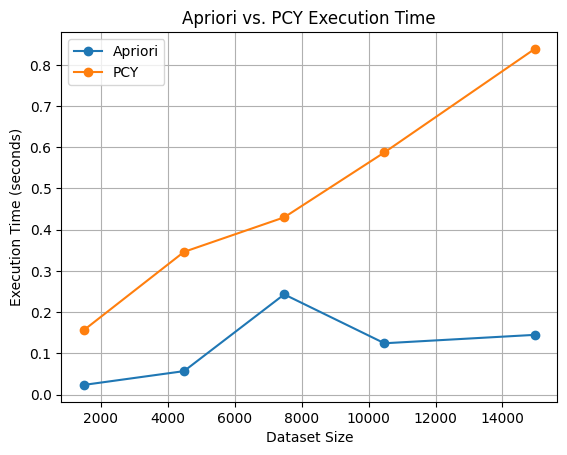

In [ ]:
apriori_extime = execute_algorithms(data, dataset_sizes, Apriori,
                                                params=[min_support])

pcy_extime = execute_algorithms(data, dataset_sizes, PCY,
                                        params=[min_support, num_buckets])

plt.plot(dataset_sizes, apriori_extime, marker='o',
                                            linestyle='-', label="Apriori")

plt.plot(dataset_sizes, pcy_extime, marker='o',
                                                linestyle='-', label="PCY")

plt.xlabel("Dataset Size")
plt.ylabel("Execution Time (seconds)")
plt.title("Apriori vs. PCY Execution Time")
plt.grid(True)
plt.legend()
plt.show()